# Import required libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

# Geting pre-trained model (Inception)

In [2]:
# Download the inception v3 weights
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Adding layers

In [3]:
last_layer = pre_trained_model.get_layer("mixed5")
last_output = last_layer.output 

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 7, 7, 160)    179200      activation_46[0][0]              
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 7, 7, 160)    480         conv2d_42[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 7, 7, 160)    480         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 7, 7, 160)    0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 7, 7, 160)    0           batch_normalization_47[0][0]     
__________

# Importing Adam optimizer and backend

In [4]:
from tensorflow.keras.optimizers import Adam 
from keras import backend as K

# Defining functions for multiple types of evaluation metrics

In [5]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy


 # Compiling the model

In [6]:
# Using a small learning rate. Adding self defined f1 score as a metric since it is a classification model
model.compile(optimizer = Adam(lr=0.001), 
              loss=focal_loss(), 
              metrics = ['accuracy',f1_m])

# Getting ImageDataGenerator and pandas framework to create training, testing and validation sets from data

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Creating training, testing and validation sets
- Path is relative to directory of original environment used.
The following is the file structure:

    /chest_xray
   
        /test
    
        /train
    
            /NORMAL
        
            /PNEUMONIA
        
        /validation
    
            /NORMAL
        
            /PNEUMONIA
    

In [8]:
base_dir = '../input/chest-xray-pneumonia/chest_xray'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_norm_dir = os.path.join(train_dir, 'NORMAL')
train_pneum_dir = os.path.join(train_dir, 'PNEUMONIA')
val_norm_dir = os.path.join(validation_dir, 'NORMAL')
val_pneum_dir = os.path.join(validation_dir, 'PNEUMONIA')

trainlabels = []
vallabels = []
traindata=[]
valdata=[]

for _ in os.listdir(train_norm_dir):
    traindata.append(train_norm_dir+"/"+_)
    trainlabels.append('NORMAL')
    
for _ in os.listdir(train_pneum_dir):
    traindata.append(train_pneum_dir+"/"+_)
    trainlabels.append('PNEUMONIA')

train=pd.DataFrame(traindata)
train.columns=['images']
train['target']=trainlabels

for _ in os.listdir(train_norm_dir):
    valdata.append(train_norm_dir+"/"+_)
    vallabels.append('NORMAL')
    
for _ in os.listdir(train_pneum_dir):
    valdata.append(train_pneum_dir+"/"+_)
    vallabels.append('PNEUMONIA')

validation=pd.DataFrame(valdata)
validation.columns=['images']
validation['target']=vallabels


from sklearn.utils import shuffle
train = shuffle(train)
validation = shuffle(validation)
train.reset_index(inplace=True, drop=True)
validation.reset_index(inplace=True, drop=True)

# Creating set of images from dataframe of file paths

In [9]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_dataframe(
                                                    train,
                                                    x_col='images',
                                                    y_col='target',
                                                    target_size=(150, 150),
                                                    batch_size=128,
                                                    shuffle=True,
                                                    validate_filenames=False,
                                                    class_mode='binary')    

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_dataframe(
                                                        validation,
                                                        x_col='images',
                                                        y_col='target',
                                                        target_size=(150, 150),
                                                        shuffle=False,
                                                        batch_size=128,
                                                        validate_filenames=False,
                                                        class_mode='binary')

test_generator =  test_datagen.flow_from_directory( test_dir,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 5216 non-validated image filenames belonging to 2 classes.
Found 5216 non-validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Running the model

In [10]:
# Define a Callback class that stops training once accuracy reaches 96.0%

history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // 128,
            validation_data = validation_generator,
            validation_steps = validation_generator.samples // 128,
            epochs = 10,
            verbose = 1)

Epoch 1/10
40/40 [==============================] - 162s 4s/step - loss: 0.6006 - accuracy: 0.5886 - f1_m: 0.5950 - val_loss: 0.0334 - val_accuracy: 0.8314 - val_f1_m: 0.8717
Epoch 2/10
40/40 [==============================] - 121s 3s/step - loss: 0.0319 - accuracy: 0.8544 - f1_m: 0.8943 - val_loss: 0.0202 - val_accuracy: 0.9104 - val_f1_m: 0.9355
Epoch 3/10
40/40 [==============================] - 121s 3s/step - loss: 0.0237 - accuracy: 0.9114 - f1_m: 0.9379 - val_loss: 0.0214 - val_accuracy: 0.8887 - val_f1_m: 0.9186
Epoch 4/10
40/40 [==============================] - 121s 3s/step - loss: 0.0190 - accuracy: 0.9283 - f1_m: 0.9502 - val_loss: 0.0102 - val_accuracy: 0.9635 - val_f1_m: 0.9749
Epoch 5/10
40/40 [==============================] - 120s 3s/step - loss: 0.0170 - accuracy: 0.9369 - f1_m: 0.9560 - val_loss: 0.0118 - val_accuracy: 0.9361 - val_f1_m: 0.9550
Epoch 6/10
40/40 [==============================] - 121s 3s/step - loss: 0.0162 - accuracy: 0.9397 - f1_m: 0.9582 - val_loss:

# Plotting the accuracy

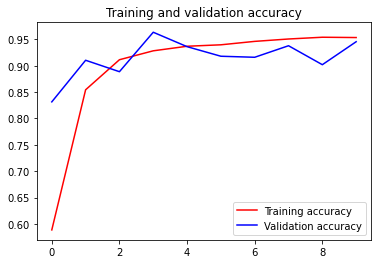

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Running the model on the test set

In [12]:
print("Loss of the model is - " , model.evaluate(test_generator)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(test_generator)[1]*100 , "%")

20/20 [==============================] - 8s 385ms/step - loss: 0.0328 - accuracy: 0.9311 - f1_m: 0.9470
Loss of the model is -  3.2762613147497177 %
20/20 [==============================] - 5s 274ms/step - loss: 0.0328 - accuracy: 0.9311 - f1_m: 0.9452
Accuracy of the model is -  93.10897588729858 %


# Results
- After running for 10 epochs we get:

accuracy: 0.9534

f1_m: 0.9680

val_loss: 0.0101

val_accuracy: 0.9455

val_f1_m: 0.9618

- After running the model on the test set we get:

accuracy: 0.9311

f1_m: 0.9470

Loss of the model is -  3.2762613147497177 %
